In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

In [3]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
df = pd.read_csv('cleaned_rock_country_hiphop_rb.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,song,artist,type,lyrics,contains_special_chars
0,Stairway to Heaven,Led Zeppelin,rock,There's a lady who's sure all that glitters is...,False
1,Like A Rolling Stone,"Dylan, Bob",rock,Once upon a time you dressed so fine Threw the...,False
2,Another Brick In The Wall,Pink Floyd,rock,We don't need no education We don't need no th...,False
3,Won't Get Fooled Again,Who,rock,We'll be fighting in the streets With our chil...,False
4,Hotel California,Eagles,rock,On a dark desert highway Cool wind in my hair ...,False


In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

In [7]:
def get_vader_scores(text):
    if pd.isna(text): return {'neg': None, 'neu': None, 'pos': None, 'compound': None}
    return vader.polarity_scores(str(text))

vader_scores = df['lyrics'].apply(get_vader_scores).apply(pd.Series)
df = pd.concat([df, vader_scores], axis=1)

category_sentiment = df.groupby('type')[['neg', 'neu', 'pos', 'compound']].mean().reset_index()

category_sentiment = category_sentiment.loc[:,~category_sentiment.columns.duplicated()]

print("\nAverage Sentiment Scores by Category:\n", category_sentiment)


Average Sentiment Scores by Category:
             type       neg       neu       pos  compound
0            R&B  0.070566  0.748777  0.180648  0.620482
1        country  0.069941  0.778674  0.151384  0.579468
2  rap & hip hop  0.130449  0.754710  0.114862 -0.197366
3           rock  0.084960  0.762134  0.152925  0.430615


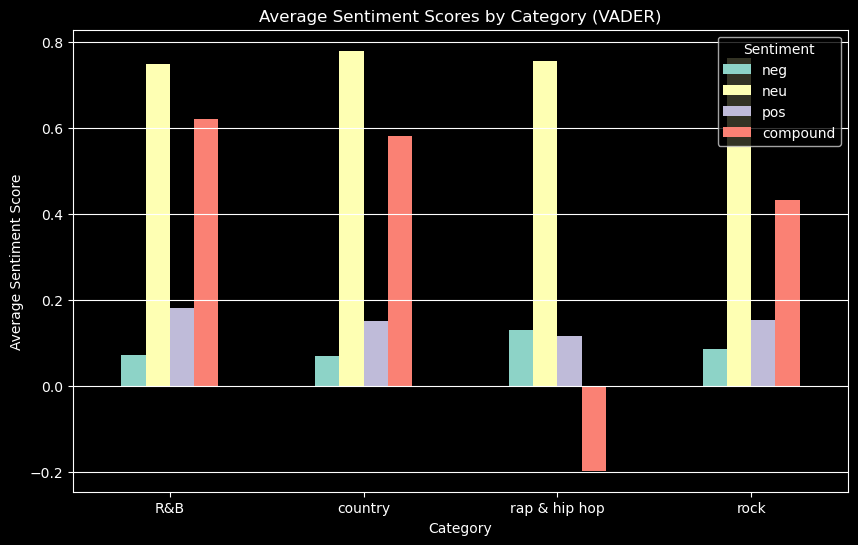

In [8]:
category_sentiment.set_index('type', inplace=True)
category_sentiment.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Average Sentiment Scores by Category (VADER)')
plt.xlabel('Category')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Sentiment')
plt.grid(axis='y')
plt.show()

VADER analysis shows that R&B and Country lyrics are generally more positive, while Rap/Hip Hop has the lowest sentiment, even trending negative overall. Rock sits somewhere in the middle, more positive than Rap/Hip Hop, but less so than R&B or Country

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words_by_category(df, column, category_column, top_n=10):
    top_words = {}
    vectorizer = CountVectorizer(stop_words='english')  # Remove common stop words
    for category in df[category_column].unique():
        # Filter lyrics by category
        category_lyrics = df[df[category_column] == category][column].dropna().str.lower()
        # Fit and transform the lyrics
        word_counts = vectorizer.fit_transform(category_lyrics)
        # Sum word frequencies
        word_freq = word_counts.sum(axis=0).A1
        # Get words and their frequencies
        words = vectorizer.get_feature_names_out()
        word_freq_dict = dict(zip(words, word_freq))
        # Sort by frequency and get top N words
        top_words[category] = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words


In [10]:
from nltk.corpus import stopwords
import re

# Download stopwords if not already downloaded
nltk.download('stopwords')

def clean_lyrics(text):
    if pd.isna(text):
        return None
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply cleaning to the lyrics column
df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)

# Use the cleaned lyrics column in get_top_words_by_category
top_words_by_category = get_top_words_by_category(df, column='cleaned_lyrics', category_column='type', top_n=10)

# Print results
for category, words in top_words_by_category.items():
    print(f"\nTop words for {category}:")
    for word, freq in words:
        print(f"{word}: {freq}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.



Top words for rock:
im: 1912
dont: 1732
oh: 1720
love: 1678
yeah: 1517
got: 1493
know: 1443
like: 1230
baby: 1084
come: 1068

Top words for country:
im: 1942
like: 1715
love: 1696
dont: 1689
know: 1427
got: 1422
little: 1042
time: 976
man: 878
oh: 821

Top words for R&B:
love: 3876
im: 2840
baby: 2838
know: 2352
dont: 2252
oh: 2182
like: 2111
got: 1670
youre: 1524
yeah: 1506

Top words for rap & hip hop:
im: 5770
like: 5118
got: 3310
feat: 2800
dont: 2725
know: 2701
aint: 2018
niggas: 1949
cause: 1934
man: 1887


In [11]:
df.head()

,song,artist,type,lyrics,contains_special_chars,neg,neu,pos,compound,cleaned_lyrics
0,Stairway to Heaven,Led Zeppelin,rock,There's a lady who's sure all that glitters is...,False,0.028,0.878,0.094,0.9653,theres lady whos sure glitters gold shes buyin...
1,Like A Rolling Stone,"Dylan, Bob",rock,Once upon a time you dressed so fine Threw the...,False,0.107,0.809,0.084,-0.7488,upon time dressed fine threw bums dime prime d...
2,Another Brick In The Wall,Pink Floyd,rock,We don't need no education We don't need no th...,False,0.155,0.789,0.055,-0.9257,dont need education dont need thought control ...
3,Won't Get Fooled Again,Who,rock,We'll be fighting in the streets With our chil...,False,0.053,0.785,0.162,0.9848,well fighting streets children feet morals wor...
4,Hotel California,Eagles,rock,On a dark desert highway Cool wind in my hair ...,False,0.035,0.837,0.129,0.9769,dark desert highway cool wind hair warm smell ...


In [ ]:
top_n = 10

top_positive = (
    df.sort_values(by='compound', ascending=False)
      .groupby('type')
      .head(top_n)
      .reset_index(drop=True)
)

top_negative = (
    df.sort_values(by='compound', ascending=True)
      .groupby('type')
      .head(top_n)
      .reset_index(drop=True)
)

top_positive['preview'] = top_positive['lyrics'].str[:150] + '...'
top_negative['preview'] = top_negative['lyrics'].str[:150] + '...'

# Display results
print("🌞 Top Positive Lyrics by Genre:\n")
print(top_positive[['type', 'compound', 'preview']])

print("\n🌧️ Top Negative Lyrics by Genre:\n")
print(top_negative[['type', 'compound', 'preview']])

🌞 Top Positive Lyrics by Genre:

             type  compound                                            preview
0   rap & hip hop    1.0000  Ain't nobody dope as me; I'm just so fresh, so...
1            rock    1.0000  that has had to come with the quarantine and t...
2             R&B    1.0000  Ulysses  LyricsI was just passing the time of ...
3             R&B    1.0000  What a pity!  I beg your pardon, my dear fello...
4   rap & hip hop    1.0000  Ulysses  LyricsThe Mabbot street entrance of n...
5         country    1.0000  Welcome to the Waking Up podcast. This is Sam ...
6         country    1.0000  Ulysses  LyricsThe Mabbot street entrance of n...
7   rap & hip hop    1.0000  Please, this shit's so fuckin' hard Helluva Be...
8            rock    1.0000  High School Musical  LyricsCUT TO: EXT. SKI LO...
9            rock    0.9999  Remarks on Climate Change at Georgetown Univer...
10  rap & hip hop    0.9999  TAFF . Since you are on for versingrhetorish s...
11           rock  